# To Do: 
- Why is there a difference between these training dynamics? 
- Try Different Ansatz (messege Hadi). 
- How similar is dist of numbers in pca_embeddings to normal? Get a p-value for each word, average over dataset for average p-value. 0.02 is threshold. 
- Some Anstaz have a much larger chance of having barren plateau, (when param < log(n)). get a fat ansatz, which solves an inner product. 
- SVD encoding.
- target 
	- 25 experiments
	- Large table, so reader cannot read every number
- Metric space conservation from hugh->low.
- consider: https://github.com/gijswijnholds/compdisteval-ellipsis/blob/master/datasets/ELLDIS.txt

	"""
	user write software - user spell software, 5
	team write software - team spell software, 5
	writer write book - writer spell book, 6
	association write book - association spell book, 6
	"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from discopy.grammar import Word
from discopy.rigid import Cup, Id, Ty
import torch
import random

from sentence_transformers import SentenceTransformer

from lambeq import LossFunction, PennyLaneModel, PytorchTrainer, QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss, Dataset, AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz, BobcatParser
from lambeq.pregroups import remove_cups
import jax as jnp
from jax import numpy as jnp

c:\Users\henry\Desktop\MastersProject\quantum_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hadi's Data

In [2]:
df = pd.read_csv('Data/HadiData.txt', sep=' ')
long_data = df.groupby(["s1w1", "s1w2", "s1w3", "s1w4", "s1w5", "s1w6", "s1w7", "s2w1", "s2w2", "s2w3", "s2w4", "s2w5", "s2w6", "s2w7"]).agg({'score': [np.mean, np.std]}).reset_index()
long_data.columns = [' '.join(col).strip() for col in long_data.columns.values]

"'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2'"


long_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
long_data['score'] = long_data['score']/long_data['score'].max()
main_dataset = pd.DataFrame()
main_dataset1 = long_data[["s1w1", "s1w2", "s1w3", "s2w5", "s2w2", "s2w3", "score", "range"]]
main_dataset1.rename(columns={"s1w1":"subject1", "s1w2":"verb1", "s1w3":"object1", "s2w5":"subject2", "s2w2":"verb2", "s2w3":"object2"}, inplace=True)
main_dataset2 = long_data[["s1w5", "s1w2", "s1w3", "s2w5", "s2w2", "s2w3", "score", "range"]]
main_dataset2.rename(columns={"s1w5":"subject1", "s1w2":"verb1", "s1w3":"object1", "s2w5":"subject2", "s2w2":"verb2", "s2w3":"object2"}, inplace=True)
main_dataset = pd.concat([main_dataset1, main_dataset2])
main_dataset = main_dataset.reset_index(drop=True)
main_dataset.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)

unique_word_list = []
for ind, row in main_dataset.iterrows():
    for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
        unique_word_list.append(i)
unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements

main_dataset.to_csv("Data/AveragedNewData.txt")

# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Rescale the 'score' column
main_dataset['score'] = scaler.fit_transform(main_dataset[['score']])

main_dataset.describe()

C:\Users\henry\AppData\Local\Temp\ipykernel_109508\2491948639.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset1.rename(columns={"s1w1":"subject1", "s1w2":"verb1", "s1w3":"object1", "s2w5":"subject2", "s2w2":"verb2", "s2w3":"object2"}, inplace=True)
C:\Users\henry\AppData\Local\Temp\ipykernel_109508\2491948639.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset2.rename(columns={"s1w5":"subject1", "s1w2":"verb1", "s1w3":"object1", "s2w5":"subject2", "s2w2":"verb2", "s2w3":"object2"}, inplace=True)


,score,range
count,864.000000,864.000000
mean,-0.188590,1.918143
std,0.428462,0.147791
min,-1.000000,1.424127
25%,-0.517294,1.819144
50%,-0.232229,1.922408
75%,0.086856,2.018687
max,1.000000,2.359929


# Sadrzadeh-Kartsaklis-Transitive WordData Import

In [3]:
# read the text file into a pandas dataframe
#df = pd.read_csv('Sadrzadeh-Kartsaklis-TransativeWordData.txt', sep=' ')
df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')

# assign column names to the dataframe
df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']

# group the data by the three sentence columns and calculate the mean and standard deviation of the score column
main_dataset = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()

# flatten the multi-level column names of the grouped data
main_dataset.columns = [' '.join(col).strip() for col in main_dataset.columns.values]

# rename the mean and std columns to 'score' and 'range' respectively
main_dataset.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
main_dataset['score'] = main_dataset['score']/main_dataset['score'].max()

unique_word_list = []
for ind, row in main_dataset.iterrows():
    for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
        unique_word_list.append(i)
unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements

main_dataset.to_csv("Data/AveragedLargerSadrKartTransative.txt")

# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Rescale the 'score' column
main_dataset['score'] = scaler.fit_transform(main_dataset[['score']])

main_dataset.describe()

,score,range
count,108.000000,108.000000
mean,-0.497859,0.923883
std,0.550354,0.538162
min,-1.000000,0.000000
25%,-0.938911,0.495386
50%,-0.744186,0.972611
75%,-0.160207,1.348797
max,1.000000,1.929594


In [4]:
#Unique datapoints:
len(main_dataset['subject1'].unique()), len(main_dataset['verb1'].unique()), len(main_dataset['object1'].unique()), len(main_dataset['subject2'].unique()), len(main_dataset['verb2'].unique()), len(main_dataset['object2'].unique())

(55, 59, 61, 51, 56, 60)

In [5]:
sent = pd.DataFrame()
sent['sent1'] = main_dataset['subject1'] + " " + main_dataset['verb1'] + " " + main_dataset['object1']
sent['sent2'] = main_dataset['subject2'] + " " + main_dataset['verb2'] + " " + main_dataset['object2']
length1 = len(sent['sent1'].unique())
length2 = len(sent['sent2'].unique())

length1, length2, length1 * length2, len(main_dataset)

(65, 63, 4095, 108)

# High-Dimension Embeddings

Create high dimensional embeddings, to compare with human annotations. This checks whether the cosine difference does actually represent the similarity in the way humans recognise it. We can then use these embeddings as baselines (or targets to aim/improve on) and work with their contituent parts in dim-reduced forms.

In [6]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
"""
    Assumes names use 1&2 eg: subject1, subject2, verb1, verb2...
    For each sentence pair, calculate the 2 embedding representations and calculate the cosine.
    I then print the correlation to this cosine difference and the human annotation
"""
main_dataset['SENT_sent_sim'] = main_dataset.apply(lambda row: 1 - cosine(embedder.encode(row['subject1'] + " " + row['verb1'] + " " + row['object1']),
                                                                       embedder.encode(row['subject2'] + " " + row['verb2'] + " " + row['object2'])), axis=1)

"""
    For each word, use the sentence embedder to find the word embedding.
    Find the cosine difference of each word pair (compare subjects, compare verbs)
    I average these cosine differences
    Find correlations to human annotations
"""
word_columns = ['subject', 'verb', 'object']
similarity_columns = ['SENT_sub_sim', 'SENT_verb_sim', 'SENT_obj_sim']
for i, col in enumerate(word_columns):
    main_dataset[similarity_columns[i]] = main_dataset.apply(lambda row: 1 - cosine(embedder.encode(row[col + '1']),
                                                                                   embedder.encode(row[col + '2'])), axis=1)

main_dataset['ave'] = main_dataset[similarity_columns].mean(axis=1)
main_dataset.corr(numeric_only=True, method='spearman')

,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626
ave,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000


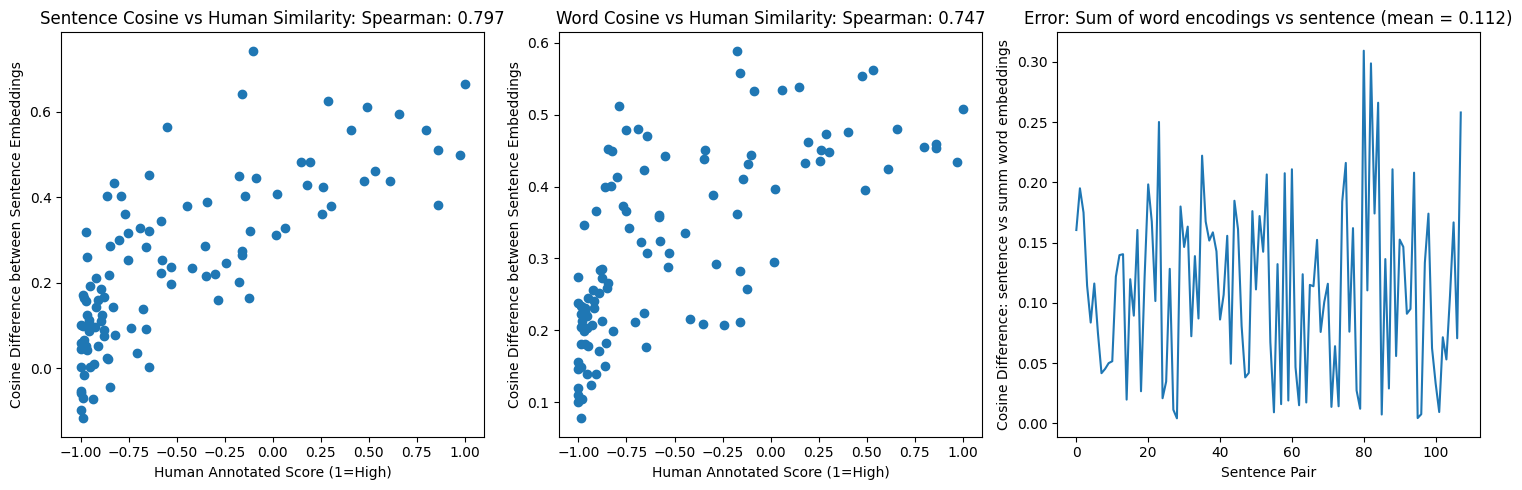

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(main_dataset['score'], main_dataset['SENT_sent_sim'])
axs[0].set_title("Sentence Cosine vs Human Similarity: Spearman: " +
                str(round(main_dataset['score'].corr(main_dataset['SENT_sent_sim'], method='spearman'), 3)))
axs[0].set_xlabel("Human Annotated Score (1=High)")
axs[0].set_ylabel("Cosine Difference between Sentence Embeddings")


axs[1].scatter(main_dataset['score'], main_dataset['ave'])
axs[1].set_title("Word Cosine vs Human Similarity: Spearman: " +
                str(round(main_dataset['score'].corr(main_dataset['ave'], method='spearman'), 3)))
axs[1].set_xlabel("Human Annotated Score (1=High)")
axs[1].set_ylabel("Cosine Difference between Sentence Embeddings")


axs[2].plot(np.sqrt((main_dataset['SENT_sent_sim'] - main_dataset['ave']) ** 2))
axs[2].set_title("Error: Sum of word encodings vs sentence (mean = " +
                str(np.round(np.sqrt((main_dataset['SENT_sent_sim'] - main_dataset['ave']) ** 2).mean(), 3)) + ")")
axs[2].set_xlabel("Sentence Pair")
axs[2].set_ylabel("Cosine Difference: sentence vs summ word embeddings")

plt.tight_layout()

plt.show()

# Dimension Reduction

In [8]:
def DimReduceByPCA(input_array, new_dims):
	#Pick new_dims Eigenvectors
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca

def DimReduceBySVD(input_array, new_dims):
    U, D, Vt = np.linalg.svd(input_array)
    U_reduced = U[:, :new_dims]
    A_reduced = np.dot(U_reduced, np.diag(D))
    return A_reduced

def RotateWordVector(input_word_vector):
	#Define word as a similarity vector compared to all the other words in corpus
	rotated_word_vector = np.zeroes(len(unique_word_list))
	for index, comaprison_word in enumerate(unique_word_list):
		rotated_word_vector[index] = (1-cosine(input_word_vector, embedder.encode(comaprison_word)))
	return rotated_word_vector

In [9]:
#Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
corpus_array = np.zeros(shape=(len(unique_word_list), 384))
word_vector_dict = {}
for i, word in enumerate(unique_word_list):
		vector = embedder.encode(word)
		word_vector_dict.update({word: {len(vector):vector}})
		corpus_array[i] = vector
		
for j in range(12):
	pca_dim = j
	pca = DimReduceByPCA(corpus_array, pca_dim)
	for i, word in enumerate(unique_word_list):
			word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})

,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave,PCA_11
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846,0.560750
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353,0.425979
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033,0.732926
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862,0.626439
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512,0.463081
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626,0.548963
ave,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000,0.765288
PCA_11,0.560750,0.425979,0.732926,0.626439,0.463081,0.548963,0.765288,1.000000


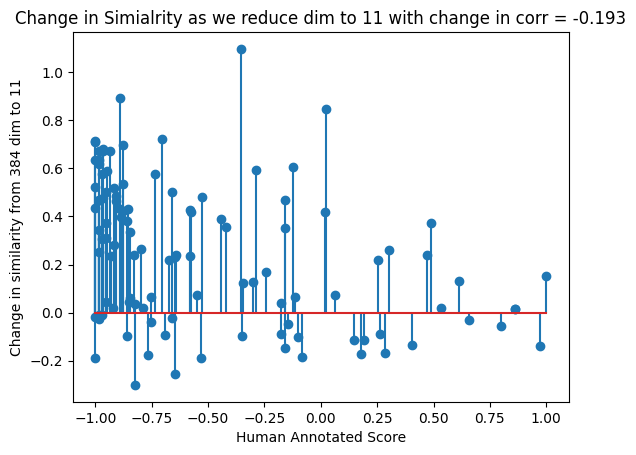

In [10]:
similarities = []
for ind, row in main_dataset.iterrows():
	rows_embeddings = []
	sent1 = word_vector_dict[row['subject1']][384] + word_vector_dict[row['verb1']][384] + word_vector_dict[row['object1']][384]
	sent2 = word_vector_dict[row['subject2']][384] + word_vector_dict[row['verb2']][384] + word_vector_dict[row['object2']][384]

	sent1_low_dim = word_vector_dict[row['subject1']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb1']]["pca_"+str(pca_dim)] + word_vector_dict[row['object1']]["pca_"+str(pca_dim)]
	sent2__low_dim = word_vector_dict[row['subject2']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb2']]["pca_"+str(pca_dim)] + word_vector_dict[row['object2']]["pca_"+str(pca_dim)]
	similarities.append([1-cosine(sent1, sent2), 1-cosine(sent1_low_dim, sent2__low_dim)])

similarities = np.array(similarities)
plt.stem(main_dataset['score'], similarities[:,0]-similarities[:,1])
plt.title("Change in Simialrity as we reduce dim to "+str(pca_dim) +" with change in corr = "+str(
	np.round(main_dataset['score'].corr(pd.Series(similarities[:,1]), method='spearman') - main_dataset['score'].corr(pd.Series(similarities[:,0]), method='spearman'), 3)
	))
plt.xlabel("Human Annotated Score")
plt.ylabel("Change in similarity from 384 dim to "+str(pca_dim))

main_dataset['PCA_'+str(pca_dim)] = similarities[:,1]
main_dataset.corr(numeric_only = True, method='spearman')

In [11]:
word_vector_dict['agent']

{384: array([-0.02489181, -0.35199916, -0.38204622, ..., -0.3539789 ,
        -0.04372901,  0.0109901 ], dtype=float32),
 'pca_0': array([], dtype=float64),
 'pca_1': array([1.40708568]),
 'pca_2': array([ 1.40708568, -1.14017986]),
 'pca_3': array([ 1.40708568, -1.14017986,  0.92208192]),
 'pca_4': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437]),
 'pca_5': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893]),
 'pca_6': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445]),
 'pca_7': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445, -0.86836529]),
 'pca_8': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445, -0.86836529,  2.41264158]),
 'pca_9': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445, -0.86836529,  2.41264158, -0.17310539]),
 'pca_10': array([ 1.40708568, -1.14017986,  0.92208192,

# Quantum Encoding

- Choose an Anzatz with invarient Inner Product

- Export circuit from lambeq/discopy to pennylane - possibly not

- tensor network module

- 12 qubits, 

- discopro - removing cups (kinianlo/discopro)

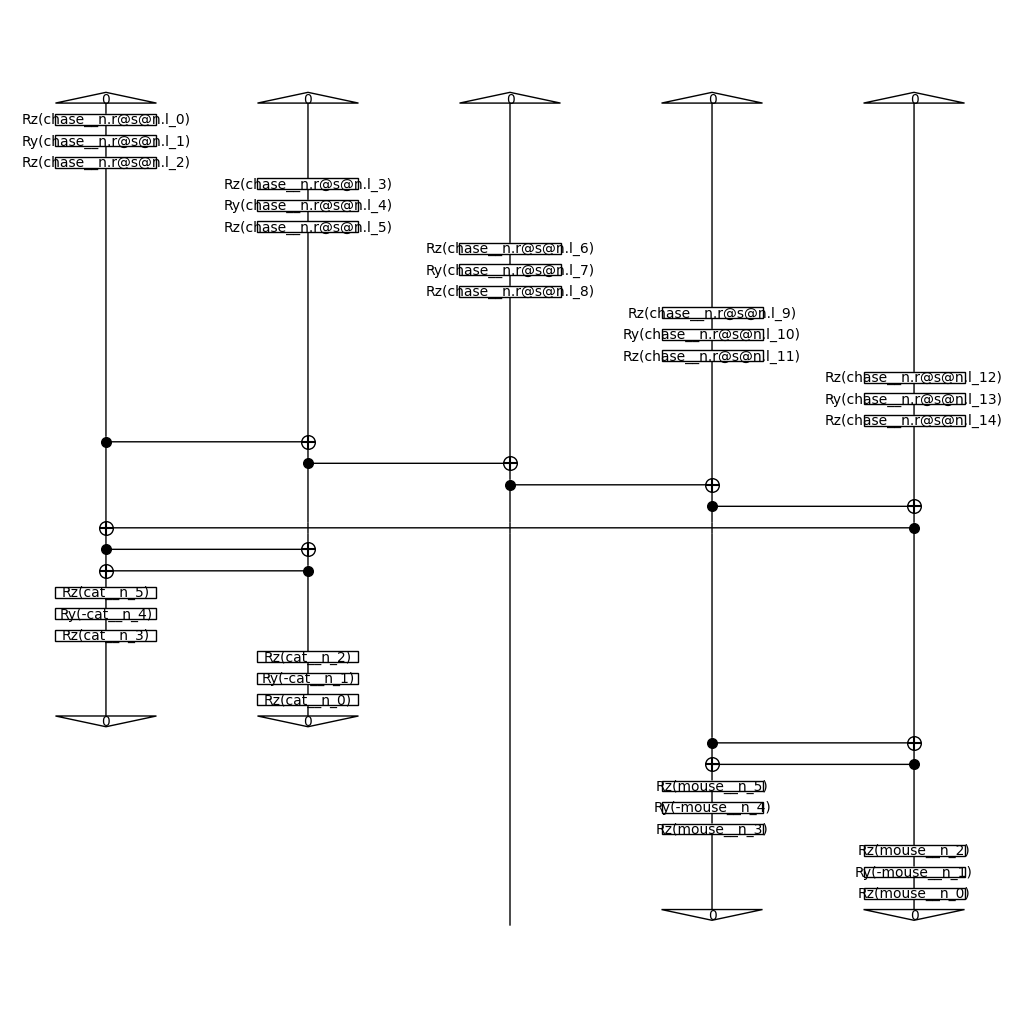

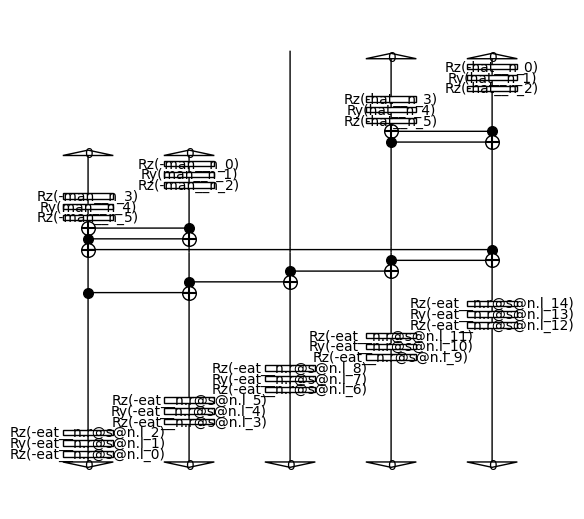

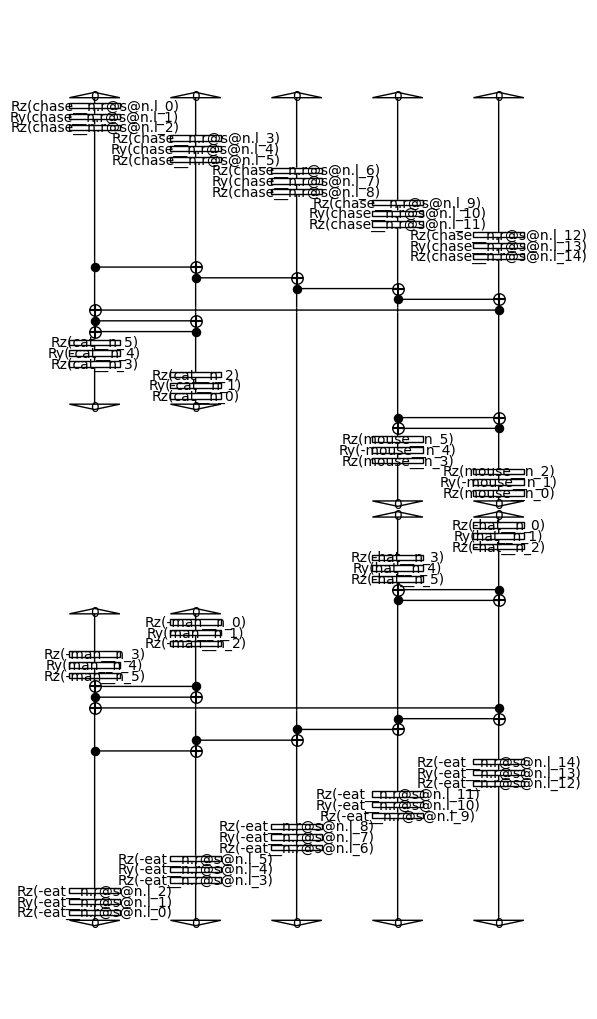

(<discopy.quantum.pennylane.PennyLaneCircuit at 0x174d8becb50>,
 Circuit(dom=Ty(), cod=Ty(), boxes=[Ket(0, 0, 0, 0, 0), Rz(chase__n.r@s@n.l_0), Ry(chase__n.r@s@n.l_1), Rz(chase__n.r@s@n.l_2), Rz(chase__n.r@s@n.l_3), Ry(chase__n.r@s@n.l_4), Rz(chase__n.r@s@n.l_5), Rz(chase__n.r@s@n.l_6), Ry(chase__n.r@s@n.l_7), Rz(chase__n.r@s@n.l_8), Rz(chase__n.r@s@n.l_9), Ry(chase__n.r@s@n.l_10), Rz(chase__n.r@s@n.l_11), Rz(chase__n.r@s@n.l_12), Ry(chase__n.r@s@n.l_13), Rz(chase__n.r@s@n.l_14), CX, CX, CX, CX, Controlled(X, distance=-4), CX, Controlled(X, distance=-1), Rz(cat__n_5), Ry(-cat__n_4), Rz(cat__n_3), Rz(cat__n_2), Ry(-cat__n_1), Rz(cat__n_0), Bra(0, 0), CX, Controlled(X, distance=-1), Rz(mouse__n_5), Ry(-mouse__n_4), Rz(mouse__n_3), Rz(mouse__n_2), Ry(-mouse__n_1), Rz(mouse__n_0), Bra(0, 0), Ket(0, 0), Rz(-hat__n_0), Ry(hat__n_1), Rz(-hat__n_2), Rz(-hat__n_3), Ry(hat__n_4), Rz(-hat__n_5), Controlled(X, distance=-1), CX, Ket(0, 0), Rz(-man__n_0), Ry(man__n_1), Rz(-man__n_2), Rz(-man__n_3), 

In [31]:
def retrive_nth_rows_sentences(data, row1, row2=None):
    if not row2:
        row2=row1
    sentence1 = data['subject'+str(1)][row1] + " " + data['verb'+str(1)][row1]  + " " + data['object'+str(1)][row1] 
    sentence2 = data['subject'+str(2)][row2] + " " + data['verb'+str(2)][row2]  + " " + data['object'+str(2)][row2] 
    return sentence1, sentence2

def make_sentence_a_state(sentence):
    diagram = diagram_to_sentence(sentence.split(" "))
    diagram = remove_cups(diagram)
    return diagram

def make_diagram_a_circuit(diagram, ansatz, dagger=False):
    discopy_circuit = ansatz(diagram)
    if dagger:
        discopy_circuit = discopy_circuit.dagger()
    return discopy_circuit

def concat_circuits_into_inner_product(circuit1, circuit2):
    concat_circuit = circuit1 >> circuit2
    return concat_circuit

def make_diagrams(data, sentence1, sentence2=None):
    if type(sentence1) == int:
        sentence1, sentence2 = retrive_nth_rows_sentences(data, sentence1, sentence2)
    diagram1 = make_sentence_a_state(sentence1)
    diagram2 = make_sentence_a_state(sentence2)
    return diagram1, diagram2

def diagram_to_sentence(word_list):
    n, s = Ty('n'), Ty('s')
    words = [
        Word(word_list[0], n),
        Word(word_list[1], n.r @ s @ n.l),
        Word(word_list[2], n)
    ]
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
    assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
    assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l
    diagram = Id().tensor(*words) >> cups
    return diagram

def plot_model_over_training(trainer):
    """
    Plots the training of a model in two graphs:
        - Traing Loss vs validation Loss, colour is epoch
        - Two Losses against epochs. 
    """
    epoch_count = range(trainer.epochs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.figsize=(20,10)

    ax1.scatter(trainer.val_costs,trainer.train_epoch_costs,c=epoch_count, cmap='gray')
    ax1.set_xlabel("Validation Loss")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("Loss of Validation and Training, should be a nice curve")

    ax2.set_title("Train & Val Losses")
    ax2.plot(epoch_count, trainer.val_costs, label = 'Validate')
    ax2.plot(epoch_count, trainer.train_epoch_costs, label = 'Train')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    fig.show()

def retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters):
    word = word_symbol.name.split("_")
    word_string = word[0]
    word_type = word[-2]
    if word_type == "n":
        word_dims = noun_parameters
    elif "@" in word_type:
        word_dims = subject_parameters #Dynamically calc these later
    word_index = int(word[-1])
    return word_string, word_dims, word_index

def get_word_dims_from_ansatz(ANSATZ):
    noun = ANSATZ.ob_map[Ty('n')]
    sent = ANSATZ.ob_map[Ty('s')]
    if isinstance(ANSATZ, IQPAnsatz):
        noun_parameters = 3 if noun == 1 else (noun-1)
        subject_parameters = noun + noun + sent - 1
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim14Ansatz):
        noun_parameters = 3 if noun == 1 else noun*4
        subject_parameters = 4*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim15Ansatz):
        noun_parameters = 3 if noun == 1 else noun*2
        subject_parameters = 2*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, StronglyEntanglingAnsatz):
        print("ERROR NOT IMPLEMENTED YET")
        pass

def pca_to_rotations(symbols):
    noun_parameters, subject_parameters = get_word_dims_from_ansatz(ANSATZ)

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word_string, word_dims, word_index = retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters)
        weights[i] = word_vector_dict[word_string]['pca_'+str(word_dims)][word_index]/(2*np.pi)
    return weights

def normal_distribution_to_rotations(symbols):
    noun_parameters, subject_parameters = get_word_dims_from_ansatz(ANSATZ)

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word_string, word_dims, word_index = retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters)
        
        mean_of_word = word_vector_dict[word_string][384].mean()
        std_of_word = word_vector_dict[word_string][384].std()
        s = np.random.normal(mean_of_word, std_of_word, 1)

        weights[i] = s
    return weights

def make_circuit_from_diagrams(diagram1, diagram2, ansatz, drawing=False):
    discopy_circuit1 = make_diagram_a_circuit(diagram1, ansatz)
    discopy_circuit2 = make_diagram_a_circuit(diagram2, ansatz, dagger=True)
    discopy_circuit = concat_circuits_into_inner_product(discopy_circuit1, discopy_circuit2)

    if drawing:
        discopy_circuit1.draw(figsize=(10, 10))
        discopy_circuit2.draw(figsize=(5, 5))
        discopy_circuit.draw(figsize=(5, 10))   

    pennylane_circuit = discopy_circuit.to_pennylane()
    return pennylane_circuit, discopy_circuit

def make_circuit_from_df_row(data, row_number, ansatz):
    diagram1, diagram2 = make_diagrams(data, row_number)
    qml_circuit, discopy_circuit = make_circuit_from_diagrams(diagram1, diagram2, ansatz, False)
    return qml_circuit, discopy_circuit

sentence1 = "cat chase mouse"
sentence2 = "man eat hat" 
qubits_noun=1
qubits_sentence=1
upload_count=1
#ansatz0 = IQPAnsatz({AtomicType.NOUN: qubits_noun, AtomicType.SENTENCE: qubits_subject}, n_layers=upload_count)
#ansatz1 = Sim14Ansatz({AtomicType.NOUN: qubits_noun, AtomicType.SENTENCE: qubits_subject}, n_layers=upload_count)
#ansatz2 = Sim15Ansatz({AtomicType.NOUN: qubits_noun, AtomicType.SENTENCE: qubits_subject}, n_layers=upload_count)
#ansatz3 = StronglyEntanglingAnsatz({AtomicType.NOUN: qubits_noun, AtomicType.SENTENCE: qubits_sentence}, n_layers=upload_count)

#Circuit from row data
#make_circuit_from_df_row(main_dataset, 3, ansatz, 1, 3)[1].draw(figsize=(5, 5))

#Plot combination circuits
ansatz = StronglyEntanglingAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1}, n_layers=1)
diagram1, diagram2 = make_diagrams(main_dataset, sentence1, sentence2)
make_circuit_from_diagrams(diagram1, diagram2, ansatz, True)

# Classically Simulated Quantum Model

No input of our classically learnt parameters yet, this is just an attempt to get the circuit learnt. I will overwrite the initialise_weights() function to add in the parameters in future.

In [27]:
def plot_model_over_training(trainer):
    """
    Plots the training of a model in two graphs:
        - Traing Loss vs validation Loss, colour is epoch
        - Two Losses against epochs. 
    """
    epoch_count = range(trainer.epochs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.figsize=(20,10)

    ax1.scatter(trainer.val_costs,trainer.train_epoch_costs,c=epoch_count, cmap='gray')
    ax1.set_xlabel("Validation Loss")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("Loss of Validation and Training, should be a nice curve")

    ax2.set_title("Train & Val Losses")
    ax2.plot(epoch_count, trainer.val_costs, label = 'Validate')
    ax2.plot(epoch_count, trainer.train_epoch_costs, label = 'Train')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    fig.show()

class EncodedNumpyModel(NumpyModel):
     def initialise_weights(self, param_initialise_method) -> None:
        """
        Initialise the weights of the model.

        Raises
        ------
        ValueError
            If `model.symbols` are not initialised.
        """
        if self.param_initialise_method is not None:
            if not self.symbols:
                raise ValueError('Symbols not initialised. Instantiate through '
                                '`from_diagrams()`.')
            self.weights = param_initialise_method(self.symbols)

In [121]:
BATCH_SIZE = 2
EPOCHS = 2000
SEED = 42
NOUN_QUBIT_COUNT = 1
SENTENCE_QUBIT_COUNT = 3
ANSATZ_PARAM = {AtomicType.NOUN: NOUN_QUBIT_COUNT, AtomicType.SENTENCE: SENTENCE_QUBIT_COUNT}
ANSATZ = IQPAnsatz(ANSATZ_PARAM, n_layers=1)
OPTIMIZER_PARAM = {'a': 0.75, 'c': 0.1, 'A':0.01*EPOCHS}
DIMS_OF_MOST_ACCURATE_MODEL = 384

identifier = '' #Write description of model here
string_identifier = identifier + str(NOUN_QUBIT_COUNT)+'_'+str(SENTENCE_QUBIT_COUNT) +'_'+str(EPOCHS)+'_'+str(BATCH_SIZE)+'_'+ str(SEED)+"_"+'_'.join(str(obj) for obj in [str(i) for i in OPTIMIZER_PARAM.values()])

epoch_count = np.array([i for i in range(0, EPOCHS)])

class EncodedNumpyModel(NumpyModel):
     def initialise_weights(self) -> None:
        """
        Initialise the weights of the model.

        Raises
        ------
        ValueError
            If `model.symbols` are not initialised.
        """
        if not self.symbols:
            raise ValueError('Symbols not initialised. Instantiate through '
                            '`from_diagrams()`.')
        self.weights = self.param_initialise_method(self.symbols)

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

def map_optimiser_to_string(val):
    if type(val) == type(SPSAOptimizer):
        return "SPSA"

def map_ansatz_to_string(val):
    if type(val) == IQPAnsatz:
        return "IQP"
    if type(val) == Sim15Ansatz:
        return "Sim15"
    if type(val) == Sim14Ansatz:
        return "Sim14"
    if type(val) == StronglyEntanglingAnsatz:
        return "StronglyEntangling"


def map_loss_function_to_string(val):
    if type(val) == type(MSELoss):
        return "MSE"

GLOBAL_MODEL_PARAMETERS = {#Makes it clear that parameters are not changed at all throughout
        "BATCH_SIZE":BATCH_SIZE, 
        "EPOCHS":EPOCHS,
        "SEED":SEED,
        "ANSATZ":ANSATZ,
        "NOUN_QUBIT_COUNT":NOUN_QUBIT_COUNT,
        "VERB_QUBIT_COUNT":VERB_QUBIT_COUNT,
        "LOSS_FUNCTION":LOSS_FUNCTION, 
        "OPTIMISER":OPTIMISER,
        "OPTIMISER_PARAM": OPTIMISER_PARAM
    }

def generate_unique_model_filename(MODEL_TYPE_string):
    unique_parameters_string = "models"+"/"
    unique_parameters_string += str(MODEL_TYPE_string)
    for key, val in GLOBAL_MODEL_PARAMETERS.items():
        if key == "ANSATZ":
            val = map_ansatz_to_string(val)
        if key == "LOSS_FUNCTION":
            val = map_loss_function_to_string(val)
        if key == "OPTIMISER":
            val = map_optimiser_to_string(val)
        if key == "OPTIMISER_PARAM":
            val = '_'.join(str(obj) for obj in [str(i) for i in val.values()])
        unique_parameters_string += "_"+str(val)
    unique_parameters_string
    return unique_parameters_string

generate_unique_model_filename("random")

'models/random_2_2000_42_IQP_1_3_MSE_SPSA_0.75_0.01_20.0'

## Data

In [24]:
def get_datasets(ansatz):
    labels = grouped_data['score']

    training = pd.read_csv("Data/TrainingData.txt")
    test = pd.read_csv("Data/TestData.txt")

    train_data =  [make_circuit_from_df_row(training, i, ansatz)[1] for i in range(len(training))]
    train_labels = labels[training['Unnamed: 0'].values]
    val_data = [make_circuit_from_df_row(test, i, ansatz)[1] for i in range(len(test))] 
    val_labels = labels[test['Unnamed: 0'].values]

    diagrams = train_data + val_data

    train_dataset = Dataset(train_data,train_labels,batch_size=BATCH_SIZE)
    val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)
    return diagrams, train_dataset, val_dataset
diagrams, train_dataset, val_dataset = get_datasets(IQPAnsatz({AtomicType.NOUN: qubits_noun, AtomicType.SENTENCE: qubits_subject}, n_layers=upload_count))

# Define Models

In [25]:
random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
random_trainer = QuantumTrainer(
    random_model,
    loss_function=MSELoss(),
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams=OPTIMIZER_PARAM,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

pca_model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
pca_model.type_of_encoding = 'pca'
pca_model.param_initialise_method = pca_to_rotations
pca_model.initialise_weights()
pca_trainer = QuantumTrainer(
    pca_model,
    loss_function=MSELoss(),
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams=OPTIMIZER_PARAM,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

normal_model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
normal_model.param_initialise_method = normal_distribution_to_rotations
normal_model.initialise_weights()
normal_trainer = QuantumTrainer(
    normal_model,
    loss_function=MSELoss(),
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams=OPTIMIZER_PARAM,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

# Random Model

## Initial Runs

In [123]:
random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
random_trainer = QuantumTrainer(
    random_model,
    loss_function=GLOBAL_MODEL_PARAMETERS['LOSS_FUNCTION'](),
    epochs=GLOBAL_MODEL_PARAMETERS['EPOCHS'],
    optimizer=GLOBAL_MODEL_PARAMETERS['OPTIMISER'],
    optim_hyperparams=GLOBAL_MODEL_PARAMETERS['OPTIMISER_PARAM'],
    evaluate_on_train=True,
    verbose = 'text',
    seed=GLOBAL_MODEL_PARAMETERS['SEED'],
)
random_trainer.fit(train_dataset, val_dataset, logging_step=100)

Epoch 1:     train/loss: 0.5318   valid/loss: 0.5851
Epoch 2000:  train/loss: 0.5300   valid/loss: 0.5851

Training completed!


In [125]:
unique_filename = generate_unique_model_filename("random")
random_model.save(unique_filename+".lt")

np.save(unique_filename+"_train"+'.npy', random_trainer.train_epoch_costs)
np.save(unique_filename+"_test"+'.npy', random_trainer.val_costs)

C:\Users\henry\AppData\Local\Temp\ipykernel_105412\2975446428.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


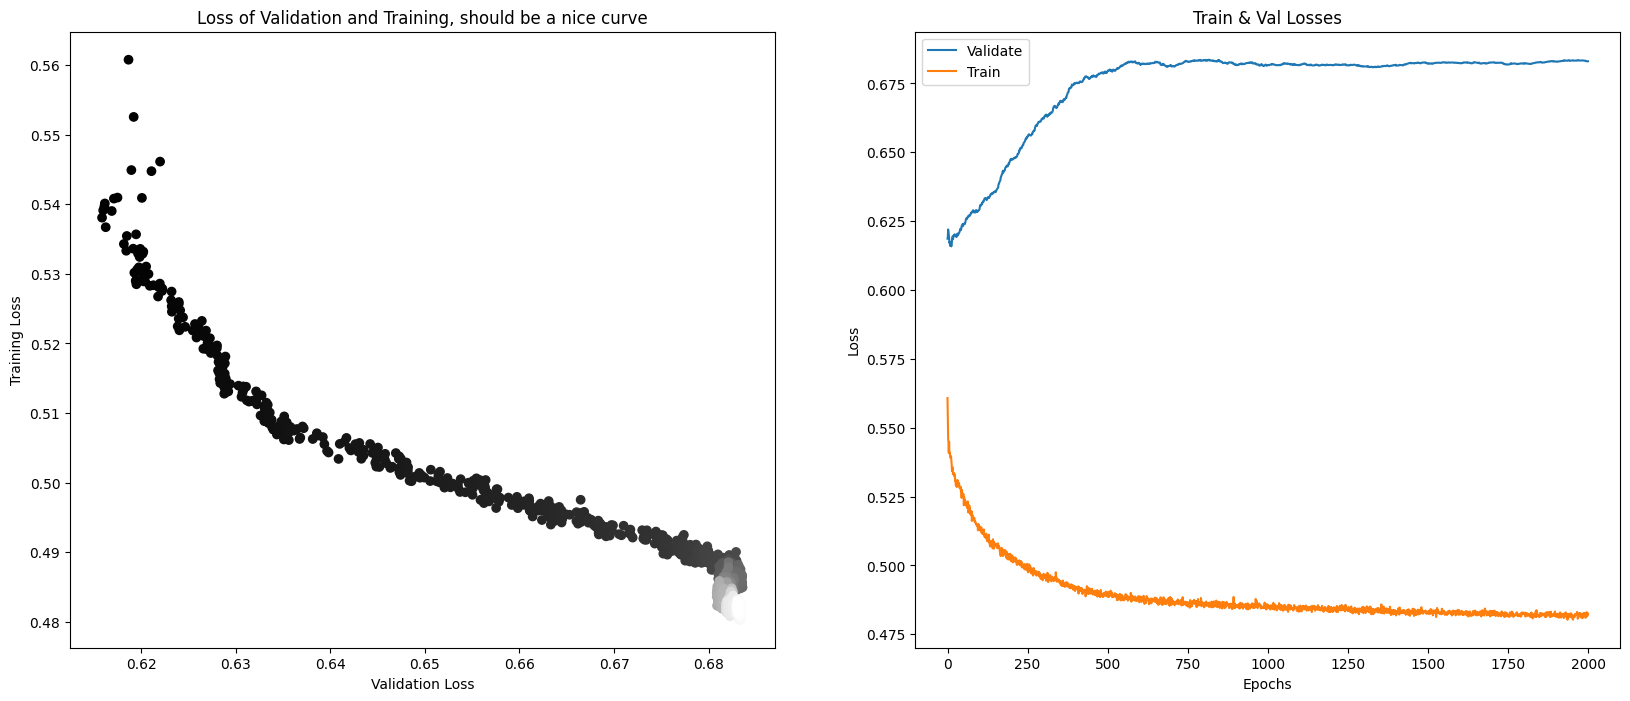

In [ ]:
plot_model_over_training(random_trainer)

## Random Model is used to HyperParameter Tune

### IQP Ansatz

In [ ]:
ANSATZ = IQPAnsatz({AtomicType.NOUN: qubits_noun, AtomicType.SENTENCE: qubits_subject}, n_layers=upload_count)

GLOBAL_MODEL_PARAMETERS = {#Makes it clear that parameters are not changed at all throughout
        "BATCH_SIZE":BATCH_SIZE, 
        "EPOCHS":EPOCHS,
        "SEED":SEED,
        "ANSATZ":ANSATZ,
        "NOUN_QUBIT_COUNT":NOUN_QUBIT_COUNT,
        "VERB_QUBIT_COUNT":VERB_QUBIT_COUNT,
        "LOSS_FUNCTION":LOSS_FUNCTION, 
        "OPTIMISER":OPTIMISER,
        "OPTIMISER_PARAM": OPTIMISER_PARAM
    }

filename = generate_unique_model_filename("random")
diagrams, train_dataset, val_dataset, overlap = get_datasets()

random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
random_trainer = QuantumTrainer(
    random_model,
    loss_function=GLOBAL_MODEL_PARAMETERS['LOSS_FUNCTION'](),
    epochs=GLOBAL_MODEL_PARAMETERS['EPOCHS'],
    optimizer=GLOBAL_MODEL_PARAMETERS['OPTIMISER'],
    optim_hyperparams=GLOBAL_MODEL_PARAMETERS['OPTIMISER_PARAM'],
    evaluate_on_train=True,
    verbose = 'text',
    seed=GLOBAL_MODEL_PARAMETERS['SEED'],
)
random_trainer.fit(train_dataset, val_dataset, logging_step=100)

random_model.save(filename+".lt")

np.save(filename+"_train"+'.npy', random_trainer.train_epoch_costs)
np.save(filename+"_test"+'.npy', random_trainer.val_costs)

plot_model_over_training(random_trainer)

### Sim15

In [ ]:
ANSATZ = Sim15Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1)

GLOBAL_MODEL_PARAMETERS = {#Makes it clear that parameters are not changed at all throughout
        "BATCH_SIZE":BATCH_SIZE, 
        "EPOCHS":EPOCHS,
        "SEED":SEED,
        "ANSATZ":ANSATZ,
        "NOUN_QUBIT_COUNT":NOUN_QUBIT_COUNT,
        "VERB_QUBIT_COUNT":VERB_QUBIT_COUNT,
        "LOSS_FUNCTION":LOSS_FUNCTION, 
        "OPTIMISER":OPTIMISER,
        "OPTIMISER_PARAM": OPTIMISER_PARAM
    }

filename = generate_unique_model_filename("random")
diagrams, train_dataset, val_dataset, overlap = get_datasets()

random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
random_trainer = QuantumTrainer(
    random_model,
    loss_function=GLOBAL_MODEL_PARAMETERS['LOSS_FUNCTION'](),
    epochs=GLOBAL_MODEL_PARAMETERS['EPOCHS'],
    optimizer=GLOBAL_MODEL_PARAMETERS['OPTIMISER'],
    optim_hyperparams=GLOBAL_MODEL_PARAMETERS['OPTIMISER_PARAM'],
    evaluate_on_train=True,
    verbose = 'text',
    seed=GLOBAL_MODEL_PARAMETERS['SEED'],
)
random_trainer.fit(train_dataset, val_dataset, logging_step=100)

random_model.save(filename+".lt")

np.save(filename+"_train"+'.npy', random_trainer.train_epoch_costs)
np.save(filename+"_test"+'.npy', random_trainer.val_costs)

plot_model_over_training(random_trainer)

### Sim14

In [ ]:
ANSATZ = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1)

GLOBAL_MODEL_PARAMETERS = {#Makes it clear that parameters are not changed at all throughout
        "BATCH_SIZE":BATCH_SIZE, 
        "EPOCHS":EPOCHS,
        "SEED":SEED,
        "ANSATZ":ANSATZ,
        "NOUN_QUBIT_COUNT":NOUN_QUBIT_COUNT,
        "VERB_QUBIT_COUNT":VERB_QUBIT_COUNT,
        "LOSS_FUNCTION":LOSS_FUNCTION, 
        "OPTIMISER":OPTIMISER,
        "OPTIMISER_PARAM": OPTIMISER_PARAM
    }

filename = generate_unique_model_filename("random")
diagrams, train_dataset, val_dataset, overlap = get_datasets()

random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
random_trainer = QuantumTrainer(
    random_model,
    loss_function=GLOBAL_MODEL_PARAMETERS['LOSS_FUNCTION'](),
    epochs=GLOBAL_MODEL_PARAMETERS['EPOCHS'],
    optimizer=GLOBAL_MODEL_PARAMETERS['OPTIMISER'],
    optim_hyperparams=GLOBAL_MODEL_PARAMETERS['OPTIMISER_PARAM'],
    evaluate_on_train=True,
    verbose = 'text',
    seed=GLOBAL_MODEL_PARAMETERS['SEED'],
)
random_trainer.fit(train_dataset, val_dataset, logging_step=100)

random_model.save(filename+".lt")

np.save(filename+"_train"+'.npy', random_trainer.train_epoch_costs)
np.save(filename+"_test"+'.npy', random_trainer.val_costs)

plot_model_over_training(random_trainer)

### StronglyEntangled

In [ ]:
ANSATZ = StronglyEntanglingAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1)

GLOBAL_MODEL_PARAMETERS = {#Makes it clear that parameters are not changed at all throughout
        "BATCH_SIZE":BATCH_SIZE, 
        "EPOCHS":EPOCHS,
        "SEED":SEED,
        "ANSATZ":ANSATZ,
        "NOUN_QUBIT_COUNT":NOUN_QUBIT_COUNT,
        "VERB_QUBIT_COUNT":VERB_QUBIT_COUNT,
        "LOSS_FUNCTION":LOSS_FUNCTION, 
        "OPTIMISER":OPTIMISER,
        "OPTIMISER_PARAM": OPTIMISER_PARAM
    }

filename = generate_unique_model_filename("random")
diagrams, train_dataset, val_dataset, overlap = get_datasets()

random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
random_trainer = QuantumTrainer(
    random_model,
    loss_function=GLOBAL_MODEL_PARAMETERS['LOSS_FUNCTION'](),
    epochs=GLOBAL_MODEL_PARAMETERS['EPOCHS'],
    optimizer=GLOBAL_MODEL_PARAMETERS['OPTIMISER'],
    optim_hyperparams=GLOBAL_MODEL_PARAMETERS['OPTIMISER_PARAM'],
    evaluate_on_train=True,
    verbose = 'text',
    seed=GLOBAL_MODEL_PARAMETERS['SEED'],
)
random_trainer.fit(train_dataset, val_dataset, logging_step=100)

random_model.save(filename+".lt")

np.save(filename+"_train"+'.npy', random_trainer.train_epoch_costs)
np.save(filename+"_test"+'.npy', random_trainer.val_costs)

plot_model_over_training(random_trainer)

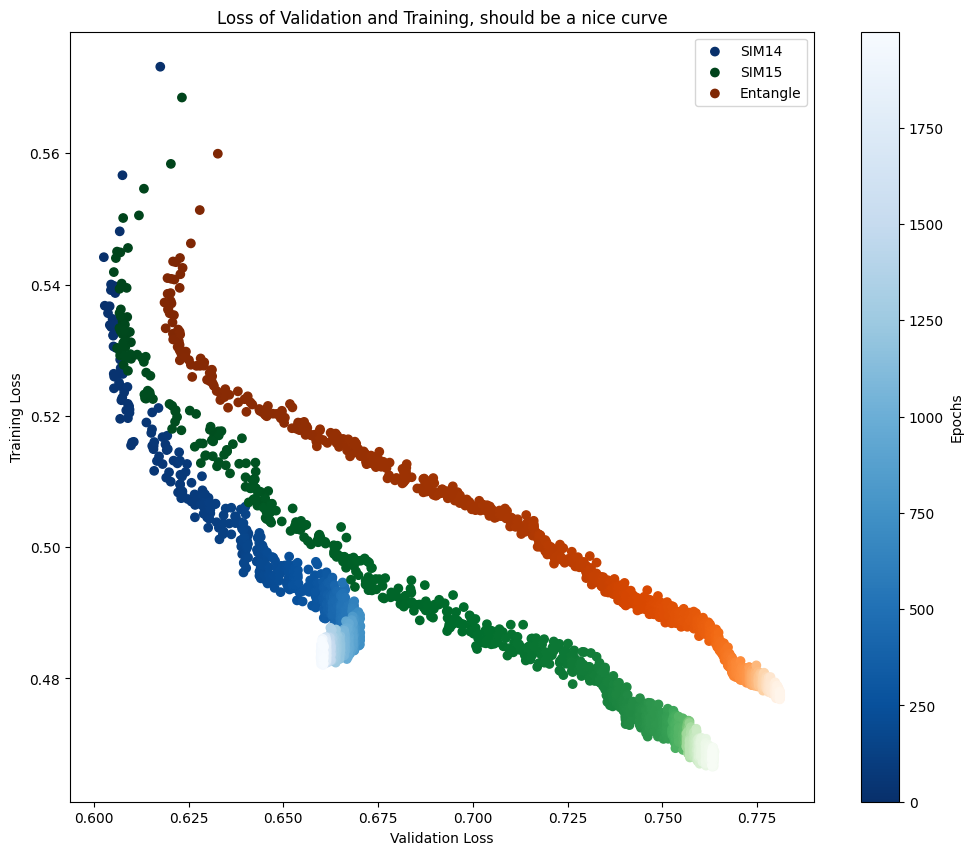

In [102]:
random_trainer_val_costs_SIM14 = np.load("models/random_2_2000_42_Sim14_1_3_MSE_SPSA_0.75_0.1_20.0_test.npy")
random_trainer_train_costs_SIM14 = np.load("models/random_2_2000_42_Sim14_1_3_MSE_SPSA_0.75_0.1_20.0_train"+'.npy')

random_trainer_val_costs_SIM15 = np.load("models/random_2_2000_42_Sim15_1_3_MSE_SPSA_0.75_0.1_20.0_test"+'.npy')
random_trainer_train_costs_SIM15 = np.load("models/random_2_2000_42_Sim15_1_3_MSE_SPSA_0.75_0.1_20.0_train"+'.npy')

random_trainer_val_costs_StronglyEntangling = np.load("models/random_2_2000_42_StronglyEntangling_1_3_MSE_SPSA_0.75_0.1_20.0_test"+'.npy')
random_trainer_train_costs_StronglyEntangling = np.load("models/random_2_2000_42_StronglyEntangling_1_3_MSE_SPSA_0.75_0.1_20.0_train"+'.npy')

random_trainer_val_costs_IQP = np.load("models/random_2_2000_42_IQP_1_3_MSE_SPSA_0.75_0.1_20.0_test"+'.npy')
random_trainer_train_costs_IQP = np.load("models/random_2_2000_42_IQP_1_3_MSE_SPSA_0.75_0.1_20.0_train"+'.npy')

epoch_count=range(2000)
ax = plt.figure(figsize=(12,10))
plt.scatter(random_trainer_val_costs_SIM14,random_trainer_train_costs_SIM14,c=epoch_count, cmap='Blues_r', label = 'SIM14')
plt.colorbar(label='Epochs')
plt.scatter(random_trainer_val_costs_SIM15,random_trainer_train_costs_SIM15,c=epoch_count, cmap='Greens_r', label = 'SIM15')
plt.scatter(random_trainer_val_costs_StronglyEntangling,random_trainer_train_costs_StronglyEntangling,c=epoch_count, cmap='Oranges_r', label = 'Entangle')
plt.scatter(random_trainer_val_costs_IQP,random_trainer_train_costs_IQP,c=epoch_count, cmap='Oranges_r', label = 'IQP')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training")

plt.legend()

# PCA Encoded Model

In [ ]:
def pca_to_rotations(symbols):
    noun_parameters = 3 if NOUN_QUBIT_COUNT == 1 else (NOUN_QUBIT_COUNT-1)
    subject_parameters = NOUN_QUBIT_COUNT + NOUN_QUBIT_COUNT + VERB_QUBIT_COUNT - 1

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word_string, word_dims, word_index = retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters)
        weights[i] = word_vector_dict[word_string]['pca_'+str(word_dims)][word_index]/(2*np.pi)
    return weights

pca_model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)

pca_model.initialise_weights(pca_to_rotations)
pca_trainer = QuantumTrainer(
    pca_model,
    loss_function=GLOBAL_MODEL_PARAMETERS['LOSS_FUNCTION'](),
    epochs=GLOBAL_MODEL_PARAMETERS['EPOCHS'],
    optimizer=GLOBAL_MODEL_PARAMETERS['OPTIMISER'],
    optim_hyperparams=GLOBAL_MODEL_PARAMETERS['OPTIMISER_PARAM'],
    evaluate_on_train=True,
    verbose = 'text',
    seed=GLOBAL_MODEL_PARAMETERS['SEED'],
)

In [159]:
pca_trainer.fit(train_dataset, val_dataset, logging_step=100)

pca_model.save("pca_model/pca_model_"+string_identifier+".lt")

np.save('pca_model/train_path_'+string_identifier+'.npy', pca_trainer.train_epoch_costs)
np.save('pca_model/val_path_'+string_identifier+'.npy', pca_trainer.val_costs)

Epoch 1:     train/loss: 0.1987   valid/loss: 0.1218   train/r2: 915941.8125   valid/r2: 22.4370
Epoch 100:   train/loss: 0.1077   valid/loss: 0.0873   train/r2: 22.1338   valid/r2: 12.4695
Epoch 200:   train/loss: 0.0644   valid/loss: 0.0819   train/r2: 72.6251   valid/r2: 2088.0977
Epoch 300:   train/loss: 0.0419   valid/loss: 0.0853   train/r2: 50.6227   valid/r2: 46.2277
Epoch 400:   train/loss: 0.0332   valid/loss: 0.0867   train/r2: 4.1969   valid/r2: 708.8431
Epoch 500:   train/loss: 0.0259   valid/loss: 0.0862   train/r2: 4.0799   valid/r2: 106.1403
Epoch 600:   train/loss: 0.0229   valid/loss: 0.0865   train/r2: 133.1810   valid/r2: 7.2254
Epoch 700:   train/loss: 0.0203   valid/loss: 0.0881   train/r2: 38014.1055   valid/r2: 15.3720
Epoch 800:   train/loss: 0.0190   valid/loss: 0.0877   train/r2: 1.6307   valid/r2: 426.5564
Epoch 900:   train/loss: 0.0168   valid/loss: 0.0883   train/r2: 37.9577   valid/r2: 14320723.0000
Epoch 1000:  train/loss: 0.0159   valid/loss: 0.0882   

C:\Users\henry\AppData\Local\Temp\ipykernel_100740\331374358.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


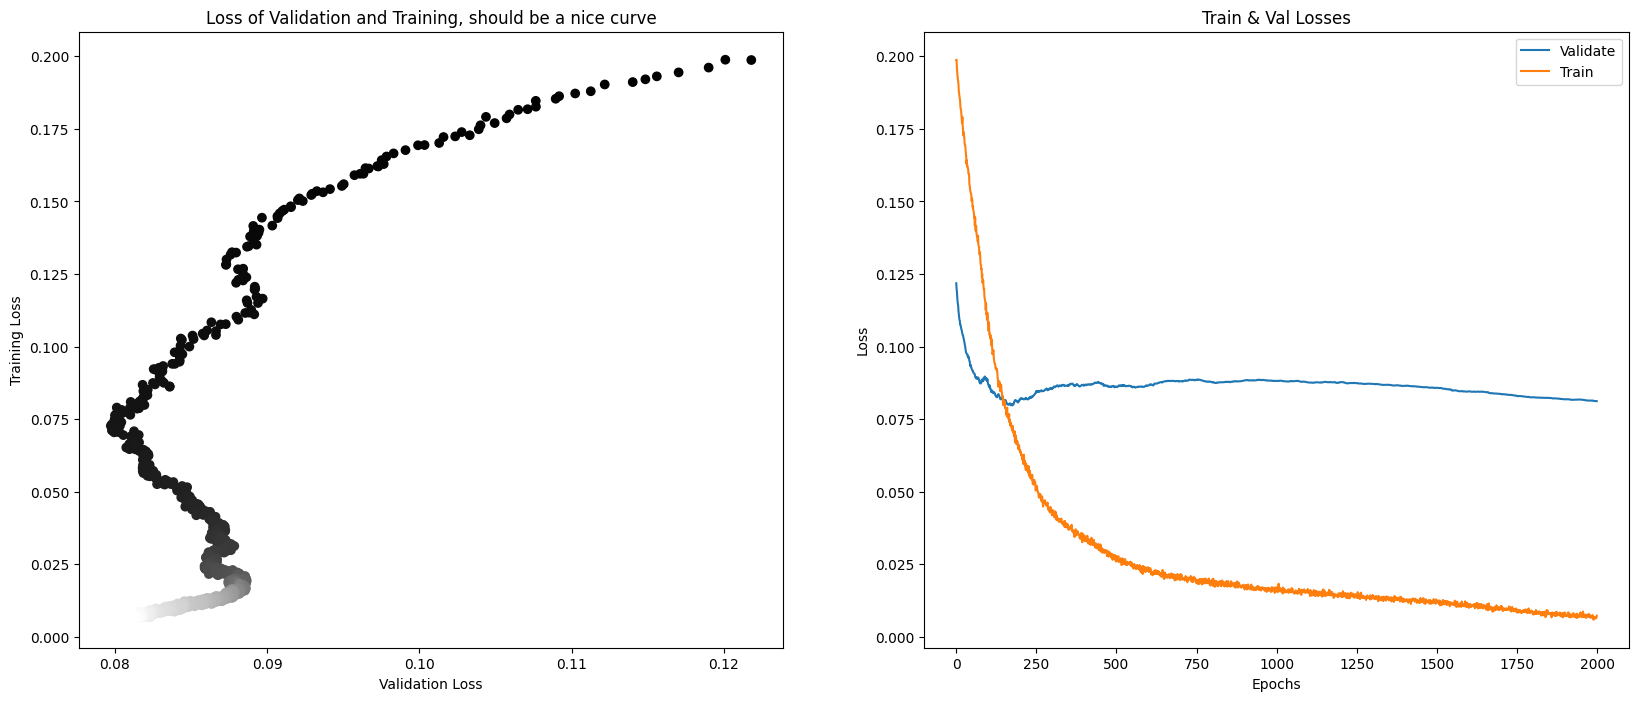

In [160]:
plot_model_over_training(pca_trainer)

# Normal Distribution Encoded Model

In [ ]:
def normal_distribution_to_rotations(symbols):
    noun_parameters = 3 if NOUN_QUBIT_COUNT == 1 else (NOUN_QUBIT_COUNT-1)
    subject_parameters = NOUN_QUBIT_COUNT + NOUN_QUBIT_COUNT + VERB_QUBIT_COUNT - 1

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word_string, word_dims, word_index = retrive_word_param_from_symbols(word_symbol, noun_parameters, subject_parameters)
        
        mean_of_word = word_vector_dict[word_string][DIMS_OF_MOST_ACCURATE_MODEL].mean()
        std_of_word = word_vector_dict[word_string][DIMS_OF_MOST_ACCURATE_MODEL].std()
        s = np.random.normal(mean_of_word, std_of_word, 1)

        weights[i] = s
    return weights

normal_model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True) 
normal_model.initialise_weights(normal_distribution_to_rotations)
normal_trainer = QuantumTrainer(
    normal_model,
    loss_function=GLOBAL_MODEL_PARAMETERS['LOSS_FUNCTION'],
    epochs=GLOBAL_MODEL_PARAMETERS['EPOCHS'],
    optimizer=GLOBAL_MODEL_PARAMETERS['OPTIMISER'],
    optim_hyperparams=GLOBAL_MODEL_PARAMETERS['OPTIMISER_PARAM'],
    evaluate_on_train=True,
    verbose = 'text',
    seed=GLOBAL_MODEL_PARAMETERS['SEED'],
)

In [1]:
normal_trainer.fit(train_dataset, val_dataset, logging_step=100)
normal_model.save("normal_model/normal_model_"+string_identifier+".lt")

np.save('normal_model/train_path_'+string_identifier+'.npy', normal_trainer.train_epoch_costs)
np.save('normal_model/val_path_'+string_identifier+'.npy', normal_trainer.val_costs)

NameError: name 'normal_trainer' is not defined

C:\Users\henry\AppData\Local\Temp\ipykernel_100740\331374358.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


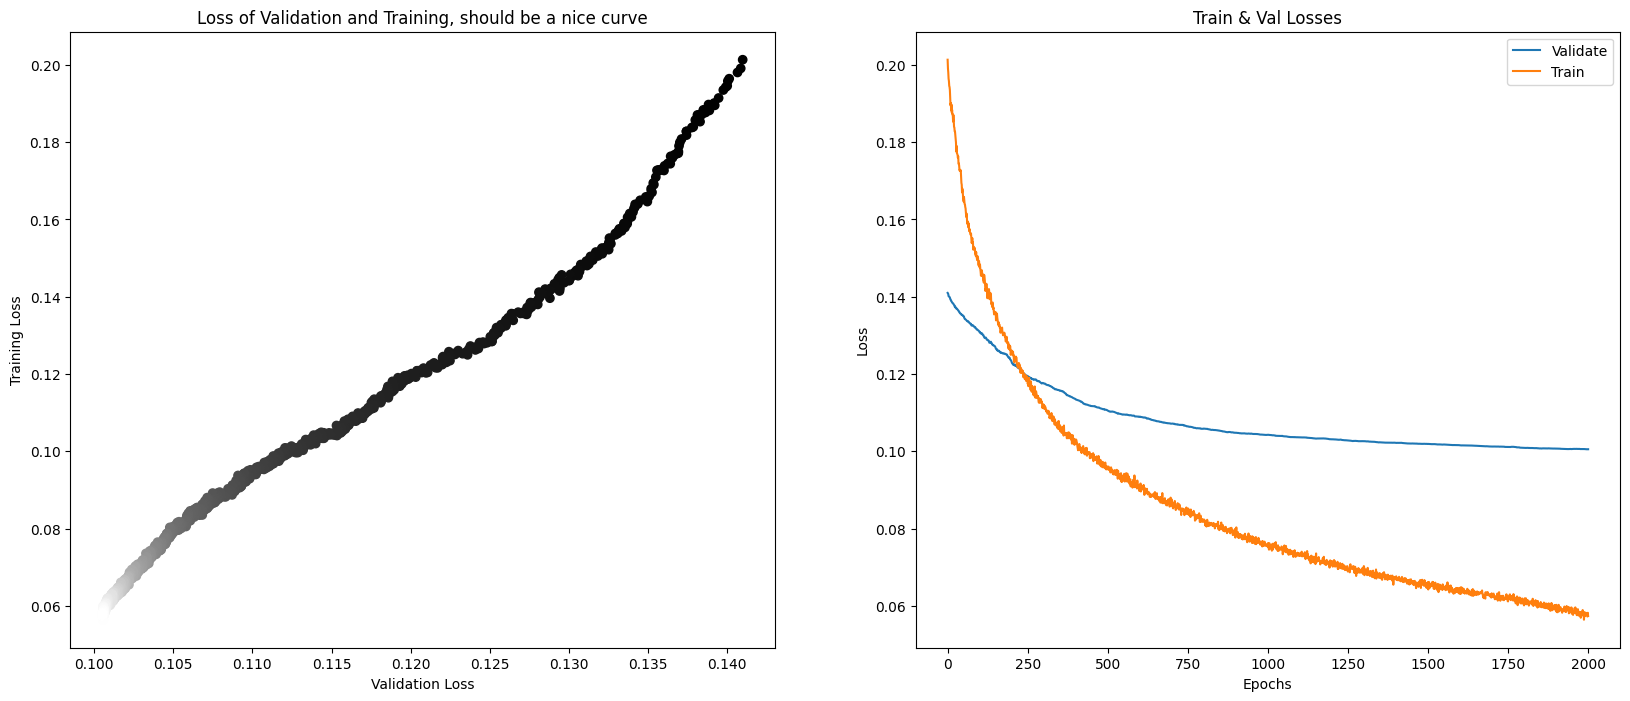

In [162]:
plot_model_over_training(normal_trainer)

# Compare

In [164]:
random_model = NumpyModel.from_checkpoint('random_model/random_model_'+string_identifier+'.lt')
random_trainer_val_costs = np.load('random_model/val_path_'+string_identifier+'.npy')
random_trainer_train_costs = np.load('random_model/train_path_'+string_identifier+'.npy')

pca_model = NumpyModel.from_checkpoint('pca_model/pca_model_'+string_identifier+'.lt')
pca_trainer_val_costs = np.load('pca_model/val_path_'+string_identifier+'.npy')
pca_trainer_train_costs = np.load('pca_model/train_path_'+string_identifier+'.npy')

normal_model = NumpyModel.from_checkpoint('normal_model/normal_model_'+string_identifier+'.lt')
normal_trainer_val_costs = np.load('normal_model/val_path_'+string_identifier+'.npy')
normal_trainer_train_costs = np.load('normal_model/train_path_'+string_identifier+'.npy')

In [165]:
random_prediction = pd.Series(random_model.get_diagram_output(diagrams))
e_prediction = pd.Series(pca_model.get_diagram_output(diagrams))
normal_prediction = pd.Series(normal_model.get_diagram_output(diagrams))

print("encoded correlation: {}, random correlation: {}, normal dist correlations: {}".format(
    main_dataset['score'].corr(e_prediction, method='spearman'), 
    main_dataset['score'].corr(random_prediction, method='spearman'), 
    main_dataset['score'].corr(normal_prediction, method='spearman')))

encoded correlation: 0.0022584765199451552, random correlation: 0.02480035925382813, normal dist correlations: 0.03651680179084319


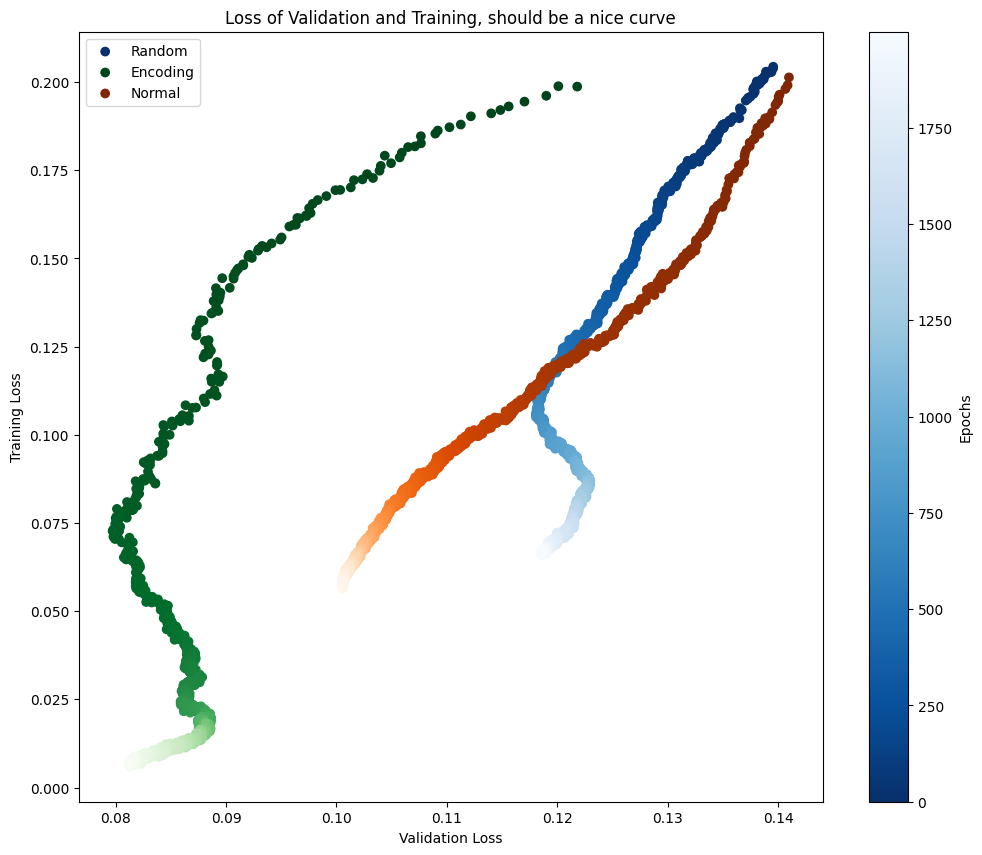

In [166]:
ax = plt.figure(figsize=(12,10))
plt.scatter(random_trainer_val_costs,random_trainer_train_costs,c=epoch_count, cmap='Blues_r', label = 'Random')
plt.colorbar(label='Epochs')
plt.scatter(pca_trainer_val_costs,pca_trainer_train_costs,c=epoch_count, cmap='Greens_r', label = 'Encoding')
plt.scatter(normal_trainer_val_costs,normal_trainer_train_costs,c=epoch_count, cmap='Oranges_r', label = 'Normal')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")

plt.legend()

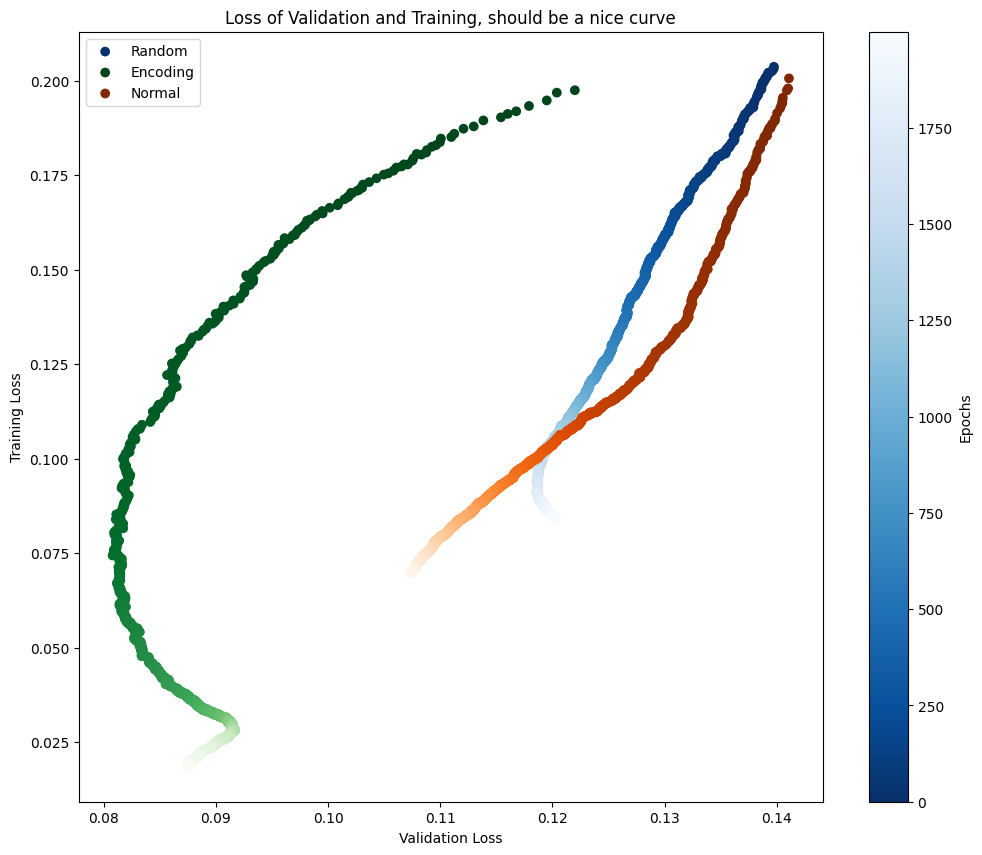

In [89]:
ax = plt.figure(figsize=(12,10))
plt.scatter(random_trainer_val_costs,random_trainer_train_costs,c=epoch_count, cmap='Blues_r', label = 'Random')
plt.colorbar(label='Epochs')
plt.scatter(pca_trainer_val_costs,pca_trainer_train_costs,c=epoch_count, cmap='Greens_r', label = 'Encoding')
plt.scatter(normal_trainer_val_costs,normal_trainer_train_costs,c=epoch_count, cmap='Oranges_r', label = 'Normal')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")

plt.legend()

# Ansatz Analysis

In [28]:
ansatzes = [IQPAnsatz, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz]
ansatz_parameters = {AtomicType.NOUN: qubits_noun, AtomicType.SENTENCE: SENTENCE_QUBIT_COUNT}

for i, a in enumerate(ansatzes):
    diagrams, train_dataset, val_dataset = get_datasets(a(ansatz_parameters, n_layers=upload_count))

    random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
    random_trainer = QuantumTrainer(
        random_model,
        loss_function=MSELoss(),
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams=OPTIMIZER_PARAM,
        evaluate_on_train=True,
        verbose = 'text',
        seed=SEED
    )

    random_trainer.fit(train_dataset, val_dataset, logging_step=100)

    random_model.save("ansatz_model/random_model_"+str(i)+".lt")

    np.save('ansatz/train_path_'+str(i)+'.npy', random_trainer.train_epoch_costs)
    np.save('ansatz/val_path_'+str(i)+'.npy', random_trainer.val_costs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Epoch 1:     train/loss: 0.5608   valid/loss: 0.6186
Epoch 100:   train/loss: 0.5131   valid/loss: 0.6292
Epoch 200:   train/loss: 0.5015   valid/loss: 0.6473
Epoch 300:   train/loss: 0.4960   valid/loss: 0.6623
Epoch 400:   train/loss: 0.4912   valid/loss: 0.6751
Epoch 500:   train/loss: 0.4899   valid/loss: 0.6794
Epoch 600:   train/loss: 0.4866   valid/loss: 0.6823
Epoch 700:   train/loss: 0.4862   valid/loss: 0.6812
Epoch 800:   train/loss: 0.4862   valid/loss: 0.6834
Epoch 900:   train/loss: 0.4858   valid/loss: 0.6819
Epoch 1000:  train/loss: 0.4847   valid/loss: 0.6816
Epoch 1100:  train/loss: 0.4833   valid/loss: 0.6816
Epoch 1200:  train/loss: 0.4842   valid/loss: 0.6816
Epoch 1300:  train/loss: 0.4848   valid/loss: 0.6812
Epoch 1400:  train/loss: 0.4832   valid/loss: 0.6818
Epoch 1500:  train/loss: 0.4829   valid/loss: 0.6823
Epoch 1600:  train/loss: 0.4823   valid/loss: 0.6824
Epoch 

FileNotFoundError: The directory does not exist. Check path `{path}`

# Random Initialisation First Epoch Loss Distribution

In [17]:
import os 
SEED = 42
for s in range(0, 42):
    BATCH_SIZE = 2
    EPOCHS = 2

    OPTIMIZER_PARAM = {'a': 0.75, 'c': 0.1, 'A':0.01*EPOCHS}
    NOUN_QUBIT_COUNT = 1
    SENTENCE_QUBIT_COUNT = 3
    EVAL_FUNCTIONS = {'r2': R2Loss()}
    DIMS_OF_MOST_ACCURATE_MODEL = 384

    identifier = '' #Write description of model here
    string_identifier = identifier + str(NOUN_QUBIT_COUNT)+'_'+str(SENTENCE_QUBIT_COUNT) +'_'+str(EPOCHS)+'_'+str(BATCH_SIZE)+'_'+ str(s)+"_"+'_'.join(str(obj) for obj in [str(i) for i in OPTIMIZER_PARAM.values()])
    file_path = "random_model/random_model_"+string_identifier+".lt"
    if os.path.exists(file_path):
        # If the file exists, skip this iteration and move to the next one
        continue
    
    epoch_count = np.array([i for i in range(0, EPOCHS)])
    
    random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
    random_trainer = QuantumTrainer(
        random_model,
        loss_function=MSELoss(),
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams=OPTIMIZER_PARAM,
        evaluate_functions=EVAL_FUNCTIONS,
        evaluate_on_train=True,
        verbose = 'text',
        seed=s
    )
    random_trainer.fit(train_dataset, val_dataset)
    random_model.save("random_model/random_model_"+string_identifier+".lt")
    np.save('random_model/train_path_'+string_identifier+'.npy', random_trainer.train_epoch_costs)
    np.save('random_model/val_path_'+string_identifier+'.npy', random_trainer.val_costs)
    
    pca_model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
    pca_model.type_of_encoding = 'pca'
    pca_model.initialise_weights()
    pca_trainer = QuantumTrainer(
        pca_model,
        loss_function=MSELoss(),
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams=OPTIMIZER_PARAM,
        evaluate_functions=EVAL_FUNCTIONS,
        evaluate_on_train=True,
        verbose = 'text',
        seed=s
    )
    pca_trainer.fit(train_dataset, val_dataset)

    pca_model.save("pca_model/pca_model_"+string_identifier+".lt")

    np.save('pca_model/train_path_'+string_identifier+'.npy', pca_trainer.train_epoch_costs)
    np.save('pca_model/val_path_'+string_identifier+'.npy', pca_trainer.val_costs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Epoch 1:  train/loss: 0.5373   valid/loss: 0.5966   train/r2: 2538.8638   valid/r2: 129709896.0000
Epoch 2:  train/loss: 0.5380   valid/loss: 0.5963   train/r2: 60342984.0000   valid/r2: 70.7379

Training completed!
Epoch 1:  train/loss: 0.5525   valid/loss: 0.6060   train/r2: 2526.2358   valid/r2: 149048928.0000
Epoch 2:  train/loss: 0.5464   valid/loss: 0.6049   train/r2: 61718252.0000   valid/r2: 73.4092

Training completed!
Epoch 1:  train/loss: 0.5442   valid/loss: 0.5939   train/r2: 8.6893   valid/r2: 331.6514
Epoch 2:  train/loss: 0.5407   valid/loss: 0.5935   train/r2: 60715804.0000   valid/r2: 3962.1021

Training completed!
Epoch 1:  train/loss: 0.5519   valid/loss: 0.6067   train/r2: 9.1667   valid/r2: 333.3315
Epoch 2:  train/loss: 0.5420   valid/loss: 0.6075   train/r2: 58333148.0000   valid/r2: 3896.8687

Training completed!


In [53]:
SEED = 42
a = []
b = []
c = []
d = []
for s in range(0, 42):
    BATCH_SIZE = 2
    EPOCHS = 2

    OPTIMIZER_PARAM = {'a': 0.75, 'c': 0.1, 'A':0.01*EPOCHS}
    NOUN_QUBIT_COUNT = 1
    SENTENCE_QUBIT_COUNT = 3
    EVAL_FUNCTIONS = {'r2': R2Loss()}
    DIMS_OF_MOST_ACCURATE_MODEL = 384

    identifier = '' #Write description of model here
    string_identifier = identifier + str(NOUN_QUBIT_COUNT)+'_'+str(SENTENCE_QUBIT_COUNT) +'_'+str(EPOCHS)+'_'+str(BATCH_SIZE)+'_'+ str(s)+"_"+'_'.join(str(obj) for obj in [str(i) for i in OPTIMIZER_PARAM.values()])
    
    try: 
        random_model = NumpyModel.from_checkpoint('random_model/random_model_'+string_identifier+'.lt')
        random_trainer_val_costs = np.load('random_model/val_path_'+string_identifier+'.npy')
        random_trainer_train_costs = np.load('random_model/train_path_'+string_identifier+'.npy')
        pca_model = NumpyModel.from_checkpoint('pca_model/pca_model_'+string_identifier+'.lt')
        pca_trainer_val_costs = np.load('pca_model/val_path_'+string_identifier+'.npy')
        pca_trainer_train_costs = np.load('pca_model/train_path_'+string_identifier+'.npy')
    except:
        print(s, "failed")
    
    a.append(random_trainer_val_costs)
    b.append(random_trainer_train_costs)
    c.append(pca_trainer_val_costs)
    d.append(pca_trainer_train_costs)

a = np.array(a)
b = np.array(b)
c = np.array(c)
d = np.array(d)

e1e2_random_train = a[:, 1] - a[:, 0]
e1e2_random_val = b[:, 1] - b[:, 0]
e1e2_pca_train = c[:, 1] - c[:, 0]
e1e2_pca_val = d[:, 1] - d[:, 0]

In [54]:
a, b, c, d

(array([[0.59520983, 0.59635119],
        [0.60399451, 0.6030183 ],
        [0.59767821, 0.59766203],
        ...,
        [0.58553909, 0.58649696],
        [0.59661628, 0.59630649],
        [0.59387214, 0.59352958]]),
 array([[0.54428733, 0.53734845],
        [0.54292825, 0.5398678 ],
        [0.54094281, 0.53815608],
        ...,
        [0.54107149, 0.53946494],
        [0.5373127 , 0.53796015],
        [0.54420428, 0.54067334]]),
 array([[0.60956333, 0.60689152],
        [0.6090364 , 0.60240581],
        [0.5983899 , 0.596401  ],
        ...,
        [0.59773185, 0.59846789],
        [0.60601433, 0.60489075],
        [0.60674887, 0.60747734]]),
 array([[0.55261662, 0.54660817],
        [0.5505577 , 0.54190138],
        [0.55067043, 0.54556646],
        ...,
        [0.55209222, 0.54257497],
        [0.55251943, 0.54635434],
        [0.55190599, 0.54203666]]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


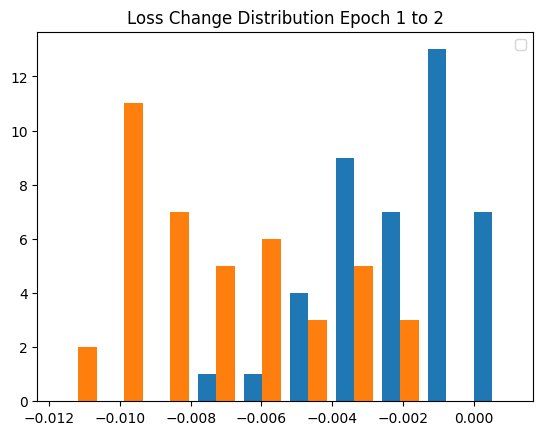

In [82]:
plt.hist([e1e2_random_val,e1e2_pca_val])
plt.title("Loss Change Distribution Epoch 1 to 2")
plt.legend()

## Repeating for lower EPOCHS:

In [52]:
EPOCHS = 300

from lambeq import QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss

lower_epoch_numpy_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
mse = MSELoss()

lower_epoch_numpy_trainer = QuantumTrainer(
    lower_epoch_numpy_model,
    loss_function=mse,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.5, 'c': 0.10, 'A':0.01*EPOCHS},
    evaluate_functions={'mse': MSELoss()},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED+1
)
lower_epoch_numpy_trainer.fit(train_dataset, val_dataset, logging_step=100)

Epoch 1:    train/loss: 0.1867   valid/loss: 0.1223   train/mse: 0.1837   valid/mse: 0.1223
Epoch 100:  train/loss: 0.1079   valid/loss: 0.1126   train/mse: 0.1055   valid/mse: 0.1126
Epoch 200:  train/loss: 0.0862   valid/loss: 0.1069   train/mse: 0.0819   valid/mse: 0.1069
Epoch 300:  train/loss: 0.0763   valid/loss: 0.1054   train/mse: 0.0748   valid/mse: 0.1054

Training completed!


In [53]:
mse = MSELoss()

lower_epoch_numpy_e_model = EncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
lower_epoch_numpy_e_model.initialise_weights()

lower_epoch_numpy_e_trainer = QuantumTrainer(
    lower_epoch_numpy_e_model,
    loss_function=mse,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.5, 'c': 0.10, 'A':0.01*EPOCHS},
    evaluate_functions={'mse': MSELoss()},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED+1
)
lower_epoch_numpy_e_trainer.fit(train_dataset, val_dataset, logging_step=100)

Epoch 1:    train/loss: 0.1910   valid/loss: 0.1261   train/mse: 0.1893   valid/mse: 0.1261
Epoch 100:  train/loss: 0.1216   valid/loss: 0.1040   train/mse: 0.1180   valid/mse: 0.1040
Epoch 200:  train/loss: 0.0961   valid/loss: 0.0985   train/mse: 0.0935   valid/mse: 0.0985
Epoch 300:  train/loss: 0.0776   valid/loss: 0.0972   train/mse: 0.0809   valid/mse: 0.0972

Training completed!


ValueError: 'c' argument has 300 elements, which is inconsistent with 'x' and 'y' with size 2000.

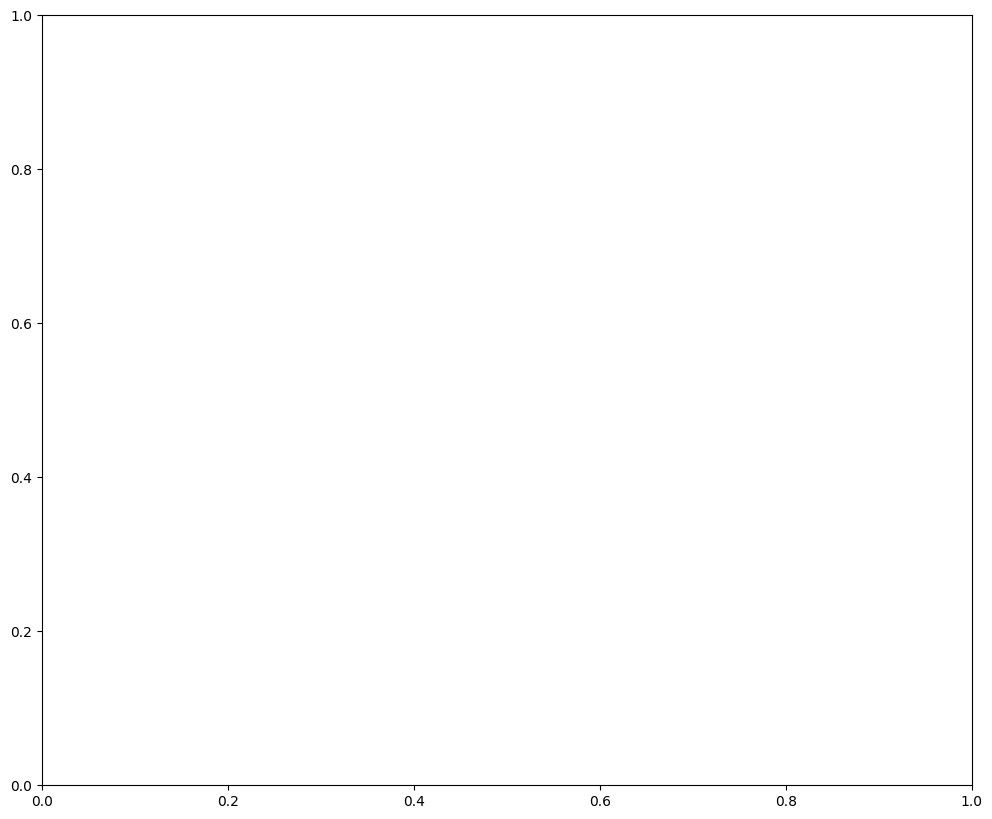

In [54]:
ax = plt.figure(figsize=(12,10))
plt.scatter(numpy_trainer.val_costs,numpy_trainer.train_epoch_costs,c=range(EPOCHS), cmap='Blues_r', label = 'Random')
plt.colorbar(label='Epochs')
plt.scatter(numpy_e_trainer.val_costs,numpy_e_trainer.train_epoch_costs,c=range(EPOCHS), cmap='Greens_r', label = 'Encoding')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()
plt.legend()

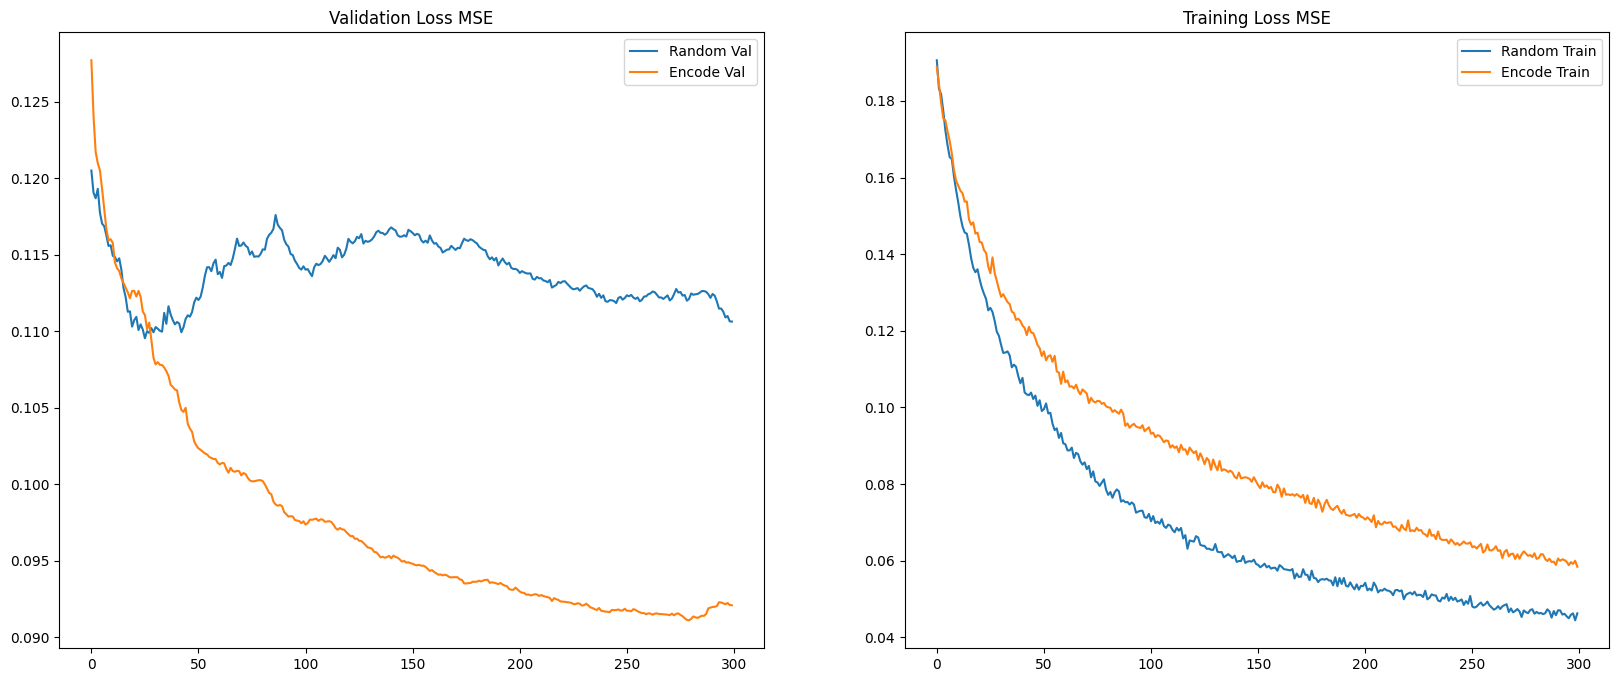

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.figsize=(30,15)

ax1.set_title("Validation Loss MSE")
ax1.plot(range(EPOCHS), numpy_trainer.val_costs, label = 'Random Val')
ax1.plot(range(EPOCHS), numpy_e_trainer.val_costs, label = 'Encode Val')
ax1.legend()

ax2.set_title("Training Loss MSE")
ax2.plot(range(EPOCHS), numpy_trainer.train_epoch_costs, label = 'Random Train')
ax2.plot(range(EPOCHS), numpy_e_trainer.train_epoch_costs, label = 'Encode Train')
ax2.legend()


## Pennylane Model

In [45]:
pennylane_model = PennyLaneModel.from_diagrams(diagrams, normalize=False)

pennylane_model.initialise_weights()

Can quantum computers learn sentence embeddings from dimensionality-reduced, classically-learnt word embeddings using the DisCoCat framework? 

In [46]:
def custom_cosine(y_hat, y):
    a_y_hat = y_hat.reshape(-1,1)
    a_y = y.reshape(-1,1)
    return torch.nn.functional.cosine_similarity(a_y_hat, a_y)
	#return torch.nn.functional.cosine_embedding_loss(a_y_hat, a_y)

pennylane_trainer = PytorchTrainer(
    model=pennylane_model,
    loss_function=torch.nn.functional.mse_loss, #
    optimizer=torch.optim.SGD , # Use SPSA, SGD
    learning_rate=2.5,
    epochs=EPOCHS,
    evaluate_functions={'mse': torch.nn.functional.mse_loss,'l1_loss':torch.nn.functional.l1_loss, 'poisson_nll':torch.nn.functional.poisson_nll_loss},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

pennylane_trainer.fit(train_dataset, val_dataset, logging_step=15)

Epoch 1:    train/loss: 0.1870   valid/loss: 0.1198   train/mse: 0.1870   train/l1_loss: 0.3565   train/poisson_nll: 1.0241   valid/mse: 0.1198   valid/l1_loss: 0.2768   valid/poisson_nll: 1.0380
Epoch 15:   train/loss: 0.1295   valid/loss: 0.1096   train/mse: 0.1295   train/l1_loss: 0.2863   train/poisson_nll: 1.0665   valid/mse: 0.1096   valid/l1_loss: 0.2531   valid/poisson_nll: 1.0571
Epoch 30:   train/loss: 0.1284   valid/loss: 0.1074   train/mse: 0.1284   train/l1_loss: 0.2810   train/poisson_nll: 1.0720   valid/mse: 0.1074   valid/l1_loss: 0.2485   valid/poisson_nll: 1.0611
Epoch 45:   train/loss: 0.1268   valid/loss: 0.1087   train/mse: 0.1268   train/l1_loss: 0.2783   train/poisson_nll: 1.0733   valid/mse: 0.1087   valid/l1_loss: 0.2498   valid/poisson_nll: 1.0607
Epoch 60:   train/loss: 0.1270   valid/loss: 0.1093   train/mse: 0.1270   train/l1_loss: 0.2778   train/poisson_nll: 1.0743   valid/mse: 0.1093   valid/l1_loss: 0.2545   valid/poisson_nll: 1.0559
Epoch 75:   train/lo

In [47]:
epoch_count = [i for i in range(0, EPOCHS)]
len(epoch_count)

300

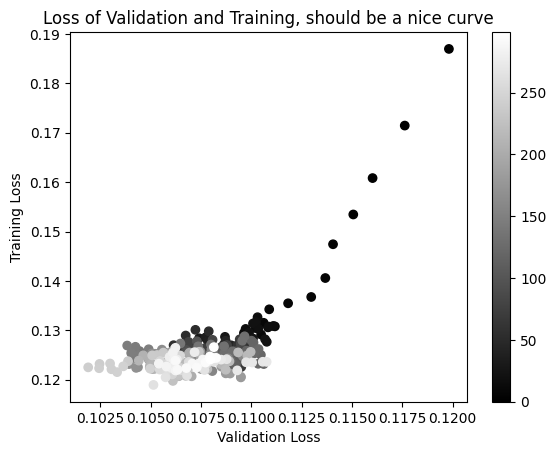

In [48]:
plt.scatter(trainer.val_costs,trainer.train_epoch_costs, c = epoch_count, cmap='gray')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()

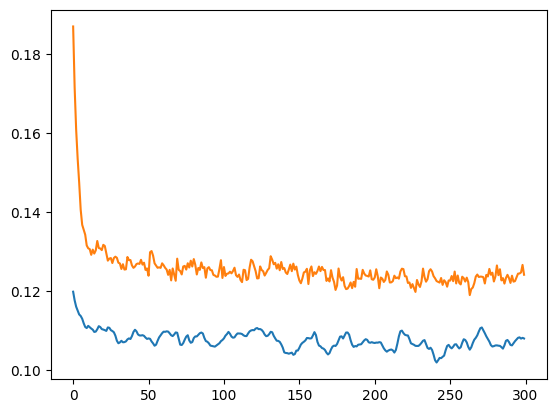

In [49]:
plt.plot(epoch_count, trainer.val_costs)
plt.plot(epoch_count, trainer.train_epoch_costs)